<a href="https://colab.research.google.com/github/FabianaAlbuquerque97/Analise-de-dados-de-imagens-medicas-para-segmentar-o-coracao/blob/main/Analise_de_dados_imagens_do_cora%C3%A7%C3%A3o_PIBIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Análises de Imagens do Coração para Segmentação**

## Connect to the dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [ ]:
IMAGES_TR_PATH = '/content/drive/MyDrive/Datasets/PIBIC/ImagesTr/'
IMAGES_PNG_PATH = '/content/drive/MyDrive/Datasets/PIBIC/ImagesPNG/'

# Parte 1

In [ ]:
# For saving data in JPG format
!pip install pillow

# For viewing medical images
!pip3 install medpy

# To view tridimentional images in different angles
!pip install SimpleITK

# To convert images from .nii to .jpg
!pip3 install med2image

# General module for color support
!pip install pfmisc

ERROR: Operation cancelled by user


####Importação das bibliotecas

In [ ]:
%matplotlib inline

import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow import keras
import numpy as np
import PIL
from PIL import Image
from medpy.io import load
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import med2image as med2image

import os

####Visualizando as imagens .NII com a biblioteca MedPy

In [ ]:
import os

for file in os.listdir(IMAGES_TR_PATH):
  if file.endswith(".nii"):
    # Load the .nii file
    i, h = sitk.ReadImage(os.path.join(IMAGES_TR_PATH, file)), sitk.ReadImage(os.path.join(IMAGES_TR_PATH, file))
    print("Shape:", i.GetSize())
    print("Pixel type:", i.GetPixelIDTypeAsString())

    # Convert to numpy array
    ct_scans = sitk.GetArrayFromImage(i)

    # Display a slice
    plt.imshow(ct_scans[21])
    plt.show()

In [ ]:
# Load the .nii file
i, h = sitk.ReadImage(os.path.join(IMAGES_TR_PATH, 'la_030.nii')), sitk.ReadImage(os.path.join(IMAGES_TR_PATH, 'la_030.nii'))
print("Shape:", i.GetSize())
print("Pixel type:", i.GetPixelIDTypeAsString())

# Convert to numpy array
ct_scans = sitk.GetArrayFromImage(i)

# Display a slice
plt.imshow(ct_scans[21])
plt.show()

# Parte 2 - Operações com OpenCV

### Importa bibliotecas necessárias

In [ ]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

### Carrega a imagem

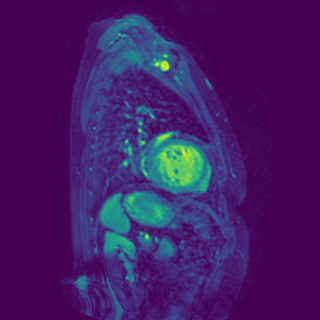

In [ ]:
original_image = cv2.imread(IMAGES_PNG_PATH + 'la_030.png')

cv2_imshow(original_image)

### Recorta a região de interesse a ser segmentada

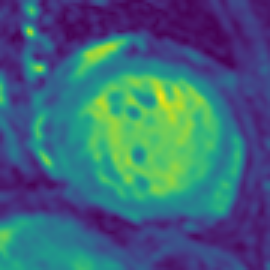

In [ ]:
# Define the coordinates of the top-left corner and the size of the square region
x, y = 130, 120  # Example coordinates
size = 90     # Example size of the square region

# Crop the square region from the image
cropped_image = original_image[y:y+size, x:x+size]

scale_factor = 3
# Resize the cropped image
scaled_image = cv2.resize(cropped_image, None, fx=scale_factor, fy=scale_factor)

image = scaled_image
cv2_imshow(image)

### Pré-processamento (original)

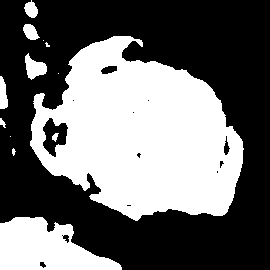

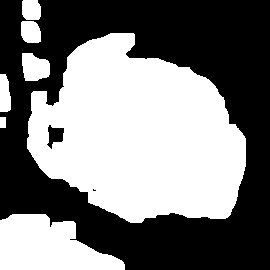

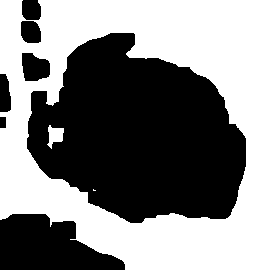

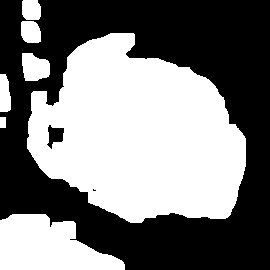

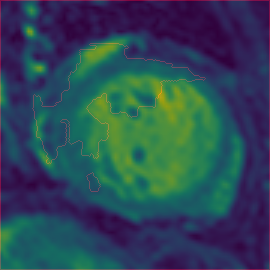

In [ ]:
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
# ret, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
ret, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cv2_imshow(threshold)

# Perform morphological opening to remove noise
kernel = np.ones((3, 3), np.uint8)  # Define the kernel for morphological operations
opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)

# Find background region
sure_bg = cv2.dilate(opening, kernel, iterations=3)
cv2_imshow(sure_bg)

# Find foreground region
# dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = cv2.bitwise_not(sure_bg)

cv2_imshow(sure_fg)

# Create marker image
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

cv2_imshow(unknown)

# Apply Watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
cv2.watershed(image, markers)


# Apply colormap to the markers
colored_markers = np.zeros_like(image)
colored_markers[markers == -1] = [0, 0, 255]  # Boundaries in red color

# Display the segmented image
segmented_image = cv2.addWeighted(image, 0.7, colored_markers, 0.3, 0)
cv2_imshow(segmented_image)

# Usando sklearn

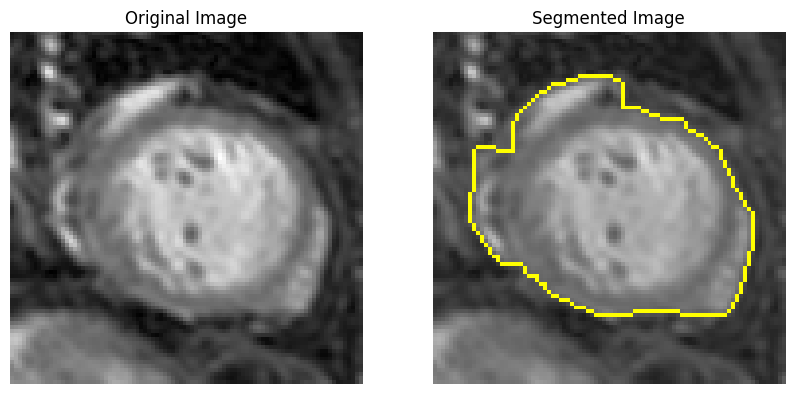

In [ ]:
import matplotlib.pyplot as plt
# from skimage import data
from skimage.io import imread
from skimage import color
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square
from skimage.color import label2rgb

# Load a sample image
original_image = imread(IMAGES_PNG_PATH + 'la_030.png')

# Discard the alpha channel if present
if original_image.shape[2] == 4:
    original_image = original_image[:, :, :3]  # Discard the alpha channel

# Convert the image to grayscale
gray_image = color.rgb2gray(original_image)

# Perform the crop
x, y = 130, 120
size = 90
image = gray_image[y:y+size, x:x+size]

# Convert the image to binary using Otsu's thresholding method
thresh = threshold_otsu(image)
binary = image > thresh

# Assuming 'binary' is your binary image
structuring_element = square(5)

# Perform morphological closing to close small gaps between objects
closed = closing(binary, structuring_element)

# Perform morphological opening to remove small noise and smooth the edges
opened = opening(closed, structuring_element)

# Remove artifacts connected to image border
cleared = clear_border(opened)

# Label regions
label_image = label(cleared)

# Get properties of labeled regions
regions = regionprops(label_image)

# Display original image with boundaries of segmented regions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(image, label_image))
plt.title('Segmented Image')
plt.axis('off')

plt.show()